In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

print("Using device:", device)

Using device: cuda


In [ ]:
class_embeddings = np.load("../aml-2025-feathers-in-focus/attributes.npy")
print(f"Original shape: {class_embeddings.shape}")
print(f"Original mean: {class_embeddings.mean():.6f}, std: {class_embeddings.std():.6f}")

# normalize embeddings (L2 normalization)
class_embeddings_normalized = class_embeddings / (np.linalg.norm(class_embeddings, axis=1, keepdims=True) + 1e-8)
print(f"Normalized mean: {class_embeddings_normalized.mean():.6f}, std: {class_embeddings_normalized.std():.6f}")


Original shape: (200, 312)
Original mean: 0.027816, std: 0.049309
Normalized mean: 0.027816, std: 0.049309


In [ ]:
train_df = pd.read_csv("/kaggle/input/dataset-aml-feathers/aml-2025-feathers-in-focus/train_images.csv")
test_df  = pd.read_csv("/kaggle/input/dataset-aml-feathers/aml-2025-feathers-in-focus/test_images_path.csv")

# transform labels to start from 0
train_df["label"] = train_df["label"] - 1

# validation with one sample per class
val_df = train_df.groupby('label').apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)

train_df = train_df.drop(val_df.index).reset_index(drop=True)

# add attribute embedding
train_df["attr_vec"] = train_df["label"].apply(lambda c: class_embeddings[c])
val_df["attr_vec"]   = val_df["label"].apply(lambda c: class_embeddings[c])

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

Train size: 3726
Val size: 200
Test size: 4000


/tmp/ipykernel_19/3287990983.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_df = train_df.groupby('label').apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)


In [5]:
class BirdDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, has_labels=True):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.has_labels = has_labels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = f"{self.img_dir}/{row['image_path']}"
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.has_labels:
            target = torch.tensor(row["attr_vec"], dtype=torch.float32)
        else:
            target = -1 * torch.ones(312, dtype=torch.float32)  # placeholder

        return image, target


In [ ]:
# same transformations as in ResNet_skinny.ipynb
train_tfms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random'),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [7]:
train_ds = BirdDataset(train_df,
                       "/kaggle/input/dataset-aml-feathers/aml-2025-feathers-in-focus/train_images",
                       train_tfms,
                       has_labels=True)

val_ds = BirdDataset(val_df,
                     "/kaggle/input/dataset-aml-feathers/aml-2025-feathers-in-focus/train_images",
                     test_tfms,
                     has_labels=True)

test_ds = BirdDataset(test_df,
                      "/kaggle/input/dataset-aml-feathers/aml-2025-feathers-in-focus/test_images",
                      test_tfms,
                      has_labels=False)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=0)

print("Train loader size:", len(train_loader))
print("Val loader size:", len(val_loader))
print("Test loader size:", len(test_loader))

Train loader size: 117
Val loader size: 7
Test loader size: 125


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.block(x)

# define the AttributeNet model with small CNN architecture
class AttributeNet(nn.Module):
    def __init__(self, output_dim=312):
        super().__init__()
        self.features = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 128)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.fc(x)
        # normalize output to L2 unit norm
        x = F.normalize(x, p=2, dim=1)
        return x


In [ ]:
def embedding_loss(pred, target, lam=0.5):
    """
    loss for embedding space learning, combines cosine similarity and MSE
    """
    # pred and target are already normalized (L2)
    cos_sim = F.cosine_similarity(pred, target, dim=1).mean()
    cos_loss = 1 - cos_sim 
    
    mse_loss = F.mse_loss(pred, target)
    
    return cos_loss + lam * mse_loss


In [ ]:
model = AttributeNet(output_dim=312).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=1e-4)
num_epochs = 150 # less epochs was tested, higher may improve further

train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)
    for images, targets in loop:
        images, targets = images.to(device), targets.to(device)

        preds = model(images) 
        loss = embedding_loss(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # gradient clipping to avoid exploding gradients
        optimizer.step()

        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # evaluation on validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False)
        for images, targets in val_loop:
            images, targets = images.to(device), targets.to(device)
            preds = model(images)
            batch_loss = embedding_loss(preds, targets).item()
            val_loss += batch_loss
            val_loop.set_postfix(val_loss=batch_loss)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # monitor progress
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "../weights/attribute_net.pth") # save best model

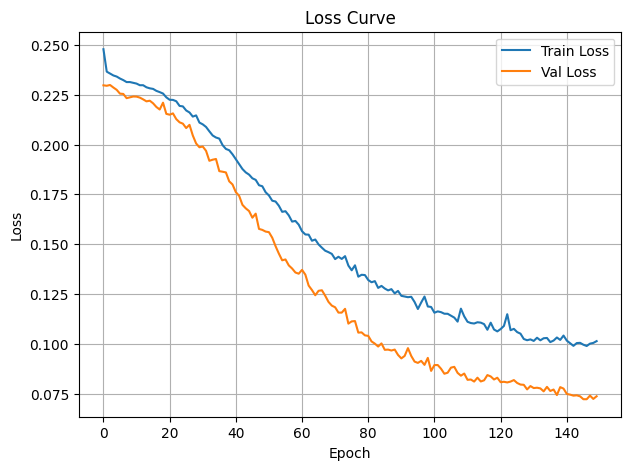

In [11]:
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# predict and save embeddings for train, val, test sets to keep same magnitude

train_loader_no_shuffle = DataLoader(train_ds, batch_size=32, shuffle=False, num_workers=0)
train_embeddings = []
with torch.no_grad():
    for images, _ in tqdm(train_loader_no_shuffle, desc="Train embeddings"):
        images = images.to(device)
        preds = model(images)
        train_embeddings.append(preds.cpu().numpy())
train_embeddings = np.vstack(train_embeddings)
np.save("embeddings/train_embeddings.npy", train_embeddings)

# validation
val_loader_no_shuffle = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
val_embeddings = []
with torch.no_grad():
    for images, _ in tqdm(val_loader_no_shuffle, desc="Val embeddings"):
        images = images.to(device)
        preds = model(images)
        val_embeddings.append(preds.cpu().numpy())
val_embeddings = np.vstack(val_embeddings)
np.save("embeddings/val_embeddings.npy", val_embeddings)

# test
test_loader_no_shuffle = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)
test_embeddings = []
with torch.no_grad():
    for images, _ in tqdm(test_loader_no_shuffle, desc="Test embeddings"):
        images = images.to(device)
        preds = model(images)
        test_embeddings.append(preds.cpu().numpy())
test_embeddings = np.vstack(test_embeddings)
np.save("embeddings/test_embeddings.npy", test_embeddings)
